In [1]:
import pandas as pd

In [7]:
df = pd.read_csv('/Users/aarohiverma/Documents/ai_vs_real/output_with_glcm_features.csv')

In [26]:
df.head()

,file_name,label,Mean_B,Mean_G,Mean_R,Contrast,Dissimilarity,Homogeneity,Energy,Correlation
0,train_data/0942b943d83e46c0be06841cdb39be0a.jpg,0,92.488075,134.449588,172.059359,0.426533,0.255988,0.886493,0.266736,0.976242
1,train_data/741de370a3e445788bf3bca324d92a46.jpg,1,73.141698,75.203761,101.551971,2.060027,0.611476,0.799970,0.345739,0.953971
2,train_data/a577eb008ee442509e9ff39553eebfff.jpg,0,75.459236,94.668139,117.948565,0.450780,0.295604,0.866751,0.227769,0.981884
3,train_data/5754c92de5514bf6bd1392fb638927da.jpg,0,156.613396,118.288030,102.231008,0.619523,0.365952,0.839179,0.225858,0.968647
4,train_data/a6dbccef6da24b89b371a2903caa6bce.jpg,0,78.517784,83.015584,87.868603,0.404527,0.244348,0.891862,0.266837,0.987868


In [17]:
correlation_with_label = df.drop(columns=["file_name"]).corr()["label"].drop("label")  
print(correlation_with_label)

Mean_B          -0.021032
Mean_G           0.078076
Mean_R           0.048194
StdDev_B         0.540125
StdDev_G         0.577446
StdDev_R         0.553746
Contrast         0.270809
Dissimilarity    0.143844
Homogeneity     -0.055814
Energy           0.041597
Correlation      0.042147
Name: label, dtype: float64


StdDev_G         0.190128
StdDev_R         0.184610
StdDev_B         0.167287
Contrast         0.079879
Mean_B           0.061643
Mean_R           0.059083
Mean_G           0.058199
Correlation      0.055784
Dissimilarity    0.049159
Homogeneity      0.048270
Energy           0.045956
dtype: float64


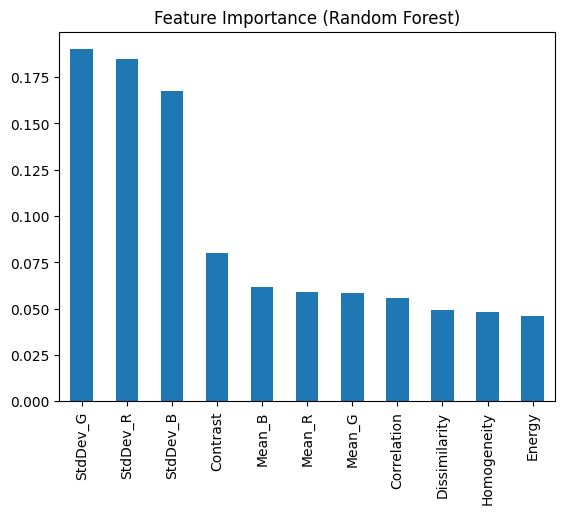

In [18]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(df.drop(columns=["file_name", "label"]), df["label"])

# Get feature importance
feature_importance = pd.Series(rf.feature_importances_, index=df.drop(columns=["file_name", "label"]).columns)
feature_importance.sort_values(ascending=False, inplace=True)

# Print or plot
print(feature_importance)
feature_importance.plot(kind="bar", title="Feature Importance (Random Forest)");


In [20]:
df = df.drop(columns=['StdDev_G', 'StdDev_R', 'StdDev_B'])


In [27]:
df = df.sample(frac=0.5).reset_index(drop=True)


In [28]:
df.shape

(39975, 10)

In [33]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import pandas as pd
import numpy as np

# ----- Constants -----
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

file_paths = df["file_name"].values  # Image paths
labels = df["label"].values.astype(np.float32)  # Target values
tabular_features = df.drop(columns=["file_name", "label"]).values.astype(np.float32)  # Tabular data

# Convert tabular data to tensor
tabular_data_tensor = tf.convert_to_tensor(tabular_features, dtype=tf.float32)

# ----- Image Preprocessing -----
def load_image(file_path):
    """Loads and preprocesses an image."""
    img = tf.io.read_file(file_path)  
    img = tf.image.decode_jpeg(img, channels=3)  
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0  # Normalize

    return img

# ----- Parse Function for TensorFlow Dataset -----
def parse_function(file_path, label, tabular_data):
    img = load_image(file_path)
    return (img, tabular_data), label  # Multi-input tuple (Image, Tabular Data)

# ----- Create TensorFlow Dataset -----
dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels, tabular_data_tensor))
dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
dataset = dataset.shuffle(5000).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

# Train-Test Split
train_size = int(0.8 * len(df)) // BATCH_SIZE
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# ----- Define Multi-Input CNN Model -----
# 🔹 CNN for Images
image_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="image_input")
base_model = EfficientNetV2B3(weights="imagenet", include_top=False)(image_input)
image_features = GlobalAveragePooling2D()(base_model)

# 🔹 MLP for Tabular Data
tabular_input = Input(shape=(tabular_features.shape[1],), name="tabular_input")
x = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(tabular_input)
x = BatchNormalization()(x)  # Regularization
x = Dropout(0.3)(x)  # Prevent overfitting
tabular_features_processed = Dense(64, activation="relu", kernel_regularizer=l2(0.01))(x)

# 🔹 Merge CNN & Tabular Data
merged = Concatenate()([image_features, tabular_features_processed])
merged = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(merged)
merged = BatchNormalization()(merged)
merged = Dropout(0.3)(merged)  # Dropout to avoid overfitting
output = Dense(1, activation="sigmoid")(merged)  # Binary classification

# 🔹 Define Model
model = Model(inputs=[image_input, tabular_input], outputs=output)

# 🔹 Compile Model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# 🔹 Train Model with Early Stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stop])

# ----- Save Model -----
model.save("test_3.h5")  # Saves in HDF5 format


Epoch 1/10


/Users/aarohiverma/Library/Python/3.9/lib/python/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_input', 'tabular_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


998/999 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.8779 - loss: 1.4124

2025-02-18 03:02:08.948257: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


999/999 ━━━━━━━━━━━━━━━━━━━━ 1847s 2s/step - accuracy: 0.8780 - loss: 1.4109 - val_accuracy: 0.6001 - val_loss: 0.8393
Epoch 2/10
999/999 ━━━━━━━━━━━━━━━━━━━━ 1782s 2s/step - accuracy: 0.9511 - loss: 0.1593 - val_accuracy: 0.6404 - val_loss: 0.6110
Epoch 3/10
999/999 ━━━━━━━━━━━━━━━━━━━━ 1849s 2s/step - accuracy: 0.9817 - loss: 0.0718 - val_accuracy: 0.6130 - val_loss: 0.6828
Epoch 4/10
999/999 ━━━━━━━━━━━━━━━━━━━━ 13627s 14s/step - accuracy: 0.9881 - loss: 0.0560 - val_accuracy: 0.5017 - val_loss: 2.0567
Epoch 5/10
999/999 ━━━━━━━━━━━━━━━━━━━━ 6696s 6s/step - accuracy: 0.9899 - loss: 0.0471 - val_accuracy: 0.7216 - val_loss: 0.9381


In [34]:
df_test = pd.read_csv('test.csv')

In [35]:
df_test.head()

,id
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg


In [36]:
import cv2
import numpy as np


# Function to calculate mean and standard deviation for color images (BGR channels)
def calculate_mean_std_color(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Calculate the mean and standard deviation for each channel (Blue, Green, Red)
    mean, std_dev = cv2.meanStdDev(image)

    # Return the values for each channel
    return mean.flatten(), std_dev.flatten()

# Initialize lists to store results
mean_values = []
std_dev_values = []

# Loop through each image file in the dataframe
for index, row in df_test.iterrows():
    image_path = row['id']  # Get the image file path
    mean, std_dev = calculate_mean_std_color(image_path)  # Calculate mean and std

    # Append the values to the lists
    mean_values.append(mean)
    std_dev_values.append(std_dev)

# Add the results as new columns to your dataframe
df_test[['Mean_B', 'Mean_G', 'Mean_R']] = pd.DataFrame(mean_values)
df_test[['StdDev_B', 'StdDev_G', 'StdDev_R']] = pd.DataFrame(std_dev_values)

# Save the updated dataframe with the mean and std values to a new CSV


# Example of viewing the result
df_test.head()


,id,Mean_B,Mean_G,Mean_R,StdDev_B,StdDev_G,StdDev_R
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg,93.827995,139.799667,141.812574,66.411804,63.292838,76.193827
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg,55.051154,66.117082,85.290761,60.792807,68.627271,77.797043
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg,171.233147,171.233147,171.233147,46.955163,46.955163,46.955163
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg,117.593816,137.974868,135.912936,65.250722,57.703197,63.568026
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg,162.191591,180.409978,200.949544,88.567894,77.400920,65.158145


In [37]:
df_test.to_csv('test_with_glcm.csv')

In [38]:
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops  # Correct based on your version

# Function to compute GLCM features for an image
def compute_glcm_features(image_path):
    # Load image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Ensure the image is valid
    if image is None:
        return [None] * 5

    # Normalize image to fit GLCM requirements (grayscale levels 0-255)
    image = (image / 255 * 15).astype(np.uint8)  # Scale to 16 gray levels

    # Compute GLCM with distance=1, angle=0 (can modify as needed)
    glcm = graycomatrix(image, distances=[1], angles=[0], levels=16, symmetric=True, normed=True)

    # Extract texture properties
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    return [contrast, dissimilarity, homogeneity, energy, correlation]

# Initialize a list to store the GLCM features
glcm_features = []


# Process each image and extract GLCM features
for index, row in df_test.iterrows():
    image_path = row['id']
    features = compute_glcm_features(image_path)
    glcm_features.append(features)

# Create new columns for GLCM features
glcm_columns = ['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation']
df_glcm = pd.DataFrame(glcm_features, columns=glcm_columns)

# Concatenate with original DataFrame
df_test = pd.concat([df_test, df_glcm], axis=1)

# Save the results to a new CSV
df_test.to_csv("test_with_pred.csv", index=False)

print("GLCM features added and saved successfully.")


GLCM features added and saved successfully.


In [42]:
df_test = df_test.drop(columns = 'Mean_R')

In [43]:
# Extract file paths from df_test
test_file_paths = df_test["id"].values  # Image paths

# Extract tabular features (excluding file_name)
tabular_test_features = df_test.drop(columns=["id"]).values.astype(np.float32)

# Convert tabular features into Tensor
tabular_test_tensor = tf.convert_to_tensor(tabular_test_features, dtype=tf.float32)


In [44]:
def load_image(file_path):
    """Load and preprocess image for prediction."""
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0  # Resize & Normalize
    return img


In [45]:
# Load and preprocess all images
image_test_tensor = tf.stack([load_image(fp) for fp in test_file_paths])


In [76]:
predictions = model.predict([image_test_tensor, tabular_test_tensor])

predicted_classes = (predictions > 0.40).astype(int)

df_test["label"] = predicted_classes



174/174 ━━━━━━━━━━━━━━━━━━━━ 59s 338ms/step


In [77]:
df_pred = df_test[["id","label"]]

df_pred.to_csv('pred_5.csv',index= False)

In [78]:
df_test.head()

,id,StdDev_B,StdDev_G,StdDev_R,Contrast,Dissimilarity,Homogeneity,Energy,Correlation,Predictions,label
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg,66.411804,63.292838,76.193827,0.569411,0.237202,0.906969,0.229963,0.980197,1,1
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg,60.792807,68.627271,77.797043,1.163743,0.541490,0.782350,0.372104,0.964919,1,1
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg,46.955163,46.955163,46.955163,0.100066,0.086178,0.958126,0.324979,0.993496,0,1
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg,65.250722,57.703197,63.568026,1.112489,0.674759,0.704810,0.164296,0.952797,1,1
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg,88.567894,77.400920,65.158145,0.211848,0.163787,0.922640,0.433236,0.994807,1,1


In [1]:
df_pred.head()

NameError: name 'df_pred' is not defined

In [80]:
df_test.drop(columns  = 'Predictions')

,id,StdDev_B,StdDev_G,StdDev_R,Contrast,Dissimilarity,Homogeneity,Energy,Correlation,label
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg,66.411804,63.292838,76.193827,0.569411,0.237202,0.906969,0.229963,0.980197,1
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg,60.792807,68.627271,77.797043,1.163743,0.541490,0.782350,0.372104,0.964919,1
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg,46.955163,46.955163,46.955163,0.100066,0.086178,0.958126,0.324979,0.993496,1
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg,65.250722,57.703197,63.568026,1.112489,0.674759,0.704810,0.164296,0.952797,1
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg,88.567894,77.400920,65.158145,0.211848,0.163787,0.922640,0.433236,0.994807,1
...,...,...,...,...,...,...,...,...,...,...
5535,test_data_v2/483412064ff74d9d9472d606b65976d9.jpg,85.294387,82.142613,67.393366,1.198369,0.513412,0.799730,0.210598,0.970626,1
5536,test_data_v2/c0b49ba4081a4197b422dac7c15aea7f.jpg,51.930706,58.844703,62.714944,0.683718,0.426757,0.810755,0.217386,0.971065,1
5537,test_data_v2/01454aaedec140c0a3ca1f48028c41cf.jpg,56.734606,55.456495,63.183854,0.383292,0.288276,0.864623,0.228424,0.980672,1
5538,test_data_v2/e9adfea8b67e4791968c4c2bdd8ec343.jpg,66.197057,67.132590,67.059980,0.594307,0.352710,0.844639,0.236397,0.980324,1
